In [ ]:
#Overlay of neural network prediction results for 80 and 256 pixel segments to cut off erroneously defined fragments
#final prediction of not sgmented images

In [1]:
import torch
import numpy as np
from torchvision.models import resnet18
import os
import shutil
import torch
from torch.utils.tensorboard import SummaryWriter

from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader,  TensorDataset
import pickle
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

import torch.optim as optim


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
# http://localhost:8888/notebooks/Documents/AI/scripts/picture_comparison_crop80.ipynbfrom tqdm import tqdm_notebook, tqdm

from scipy import misc
import imageio
import glob
from PIL import Image

# import keras as keras

# from keras_unet.utils import plot_patches
# from keras_unet.utils import get_patches
# from keras_unet.utils import reconstruct_from_patches


In [4]:
from os import listdir
from os.path import isfile, join

#path for not segmented images
mypath = r"C:\Users\adoro\Documents\AI\histology pig big/"


filename = [f for f in listdir(mypath) if isfile(join(mypath, f))]


In [5]:
filename

['EVBH3-PL10A-0_0.20.tiff',
 'EVBH3-PL10A-1_0.20.tiff',
 'EVBH3-PL10A-2_0.20.tiff',
 'EVBH3-PL10A-3_0.20.tiff',
 'EVBH3-PL10B-0_0.20.tiff',
 'EVBH3-PL10B-1_0.20.tiff',
 'EVBH3-PL10B-2_0.20.tiff',
 'EVBH3-PL10B-3_0.20.tiff',
 'EVBH3-PL10B-4_0.20.tiff',
 'EVBH3-PL1A-0_0.20.tiff',
 'EVBH3-PL1A-1_0.20.tiff',
 'EVBH3-PL1A-2_0.20.tiff',
 'EVBH3-PL1A-3_0.20.tiff',
 'EVBH3-PL1A-4_0.20.tiff',
 'EVBH3-PL1B-0_0.20.tiff',
 'EVBH3-PL1B-1_0.20.tiff',
 'EVBH3-PL1B-2_0.20.tiff',
 'EVBH3-PL1B-3_0.20.tiff',
 'EVBH3-PL1B-5_0.20.tiff',
 'EVBH3-PL2A-0_0.20.tiff',
 'EVBH3-PL2A-1_0.20.tiff',
 'EVBH3-PL2A-2_0.20.tiff',
 'EVBH3-PL2A-3_0.20.tiff',
 'EVBH3-PL2B-0_0.20.tiff',
 'EVBH3-PL2B-1_0.20.tiff',
 'EVBH3-PL2B-2_0.20.tiff',
 'EVBH3-PL2B-3_0.20.tiff',
 'EVBH3-PL2B-4_0.20.tiff',
 'EVBH3-PL2B-5_0.20.tiff',
 'EVBH3-PL3A-0_0.20.tiff',
 'EVBH3-PL3A-1_0.20.tiff',
 'EVBH3-PL3A-2_0.20.tiff',
 'EVBH3-PL3A-3_0.20.tiff',
 'EVBH3-PL3A-4_0.20.tiff',
 'EVBH3-PL3A-5_0.20.tiff',
 'EVBH3-PL3B-0_0.20.tiff',
 'EVBH3-PL3B-1_0.20

In [6]:
len(filename)

89

In [7]:
class myDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        # sample = {"image": image, "label": label}

        return image, label

In [8]:
def plot_random_Images(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  rand_num = np.random.randint(0, len_dataset, size=5)
  for img, ax in zip(images_arr[rand_num], axes):
    # img = np.round(img/np.max(img))
    ax.imshow(img.astype(int))
  plt.tight_layout()
  plt.show()
    

In [9]:
def get_patches_custom(img_arr, size=256, stride=256):
    """
    Takes single image or array of images and returns
    crops using sliding window method.
    If stride < size it will do overlapping.
    
    Args:
        img_arr (numpy.ndarray): [description]
        size (int, optional): [description]. Defaults to 256.
        stride (int, optional): [description]. Defaults to 256.
    
    Raises:
        ValueError: [description]
        ValueError: [description]
    
    Returns:
        numpy.ndarray: [description]
    """    
    # check size and stride
    if size % stride != 0:
        raise ValueError("size % stride must be equal 0")

    patches_list = []
    overlapping = 0
    if stride != size:
        overlapping = (size // stride) - 1

    if img_arr.ndim == 3:
        i_max = img_arr.shape[0] // stride - overlapping
        j_max = img_arr.shape[1] // stride - overlapping
        for i in range(i_max):
            for j in range(j_max):
                # print(i*stride, i*stride+size)
                # print(j*stride, j*stride+size)
                patches_list.append(
                    img_arr[
                        i * stride : i * stride + size,
                        j * stride : j * stride + size
                    ]
                )

    elif img_arr.ndim == 4:
        i_max = img_arr.shape[1] // stride - overlapping
        for im in img_arr:
            for i in range(i_max):
                for j in range(i_max):
                    # print(i*stride, i*stride+size)
                    # print(j*stride, j*stride+size)
                    patches_list.append(
                        im[
                            i * stride : i * stride + size,
                            j * stride : j * stride + size,
                        ]
                    )

    else:
        raise ValueError("img_arr.ndim must be equal 3 or 4")

    return np.stack(patches_list)

In [10]:
model = resnet18(pretrained=False)
model_path = r"model_weights_green_zones256_1500_1500.pth" #path for 80-pixel weights
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.float()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

device = torch.device("cpu")

In [11]:
model2 = resnet18(pretrained=False)
model2_path = r"model_weights_bs100_crop80_1A0_5000_5000.pth" #path for 256-pixel weights
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 2)
model2.load_state_dict(torch.load(model2_path, map_location=torch.device('cpu')))
model2.float()
model2.eval()

device = torch.device("cpu")

EVBH3-PL9A-0_0.20.tiff


C:\Users\adoro\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


true area, red zone:  0.0 true area, green zone:  0.0
predicted area, red zone:  0.3756384063657853 predicted area, green zone:  0.0972339527027027
EVBH3-PL9A-1_0.20.tiff
true area, red zone:  0.0 true area, green zone:  0.0
predicted area, red zone:  0.3005066704942796 predicted area, green zone:  0.10593717750257997
EVBH3-PL9A-2_0.20.tiff
true area, red zone:  0.0 true area, green zone:  0.0
predicted area, red zone:  0.25401269986006003 predicted area, green zone:  0.07491455078125
EVBH3-PL9A-3_0.20.tiff
true area, red zone:  0.0 true area, green zone:  0.0
predicted area, red zone:  0.1597535084818601 predicted area, green zone:  0.0870330810546875
EVBH3-PL9A-4_0.20.tiff
true area, red zone:  0.0 true area, green zone:  0.0
predicted area, red zone:  0.07871056639241235 predicted area, green zone:  0.06799325980392157
EVBH3-PL9A-5_0.20.tiff
true area, red zone:  0.0 true area, green zone:  0.0
predicted area, red zone:  0.01608590072448057 predicted area, green zone:  0.04891610360

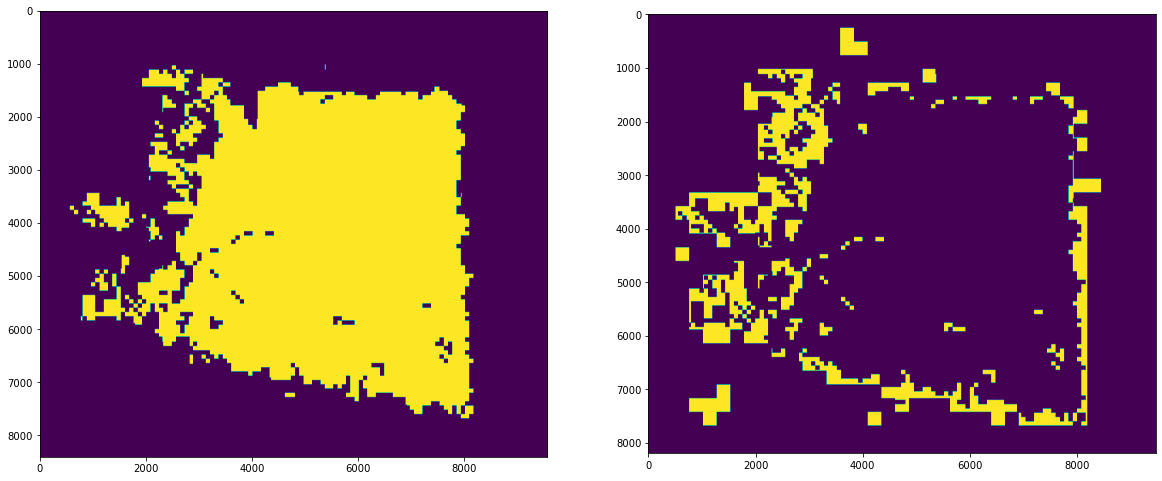

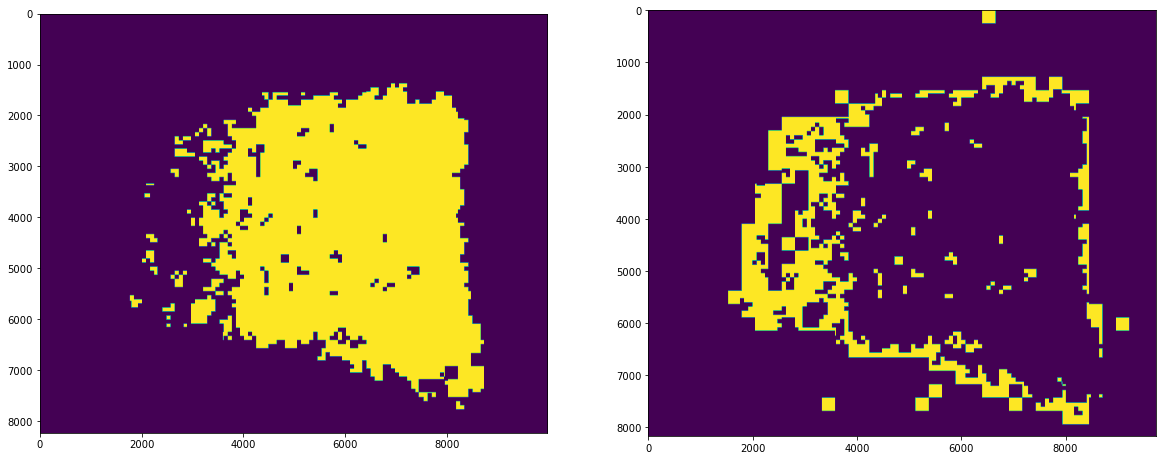

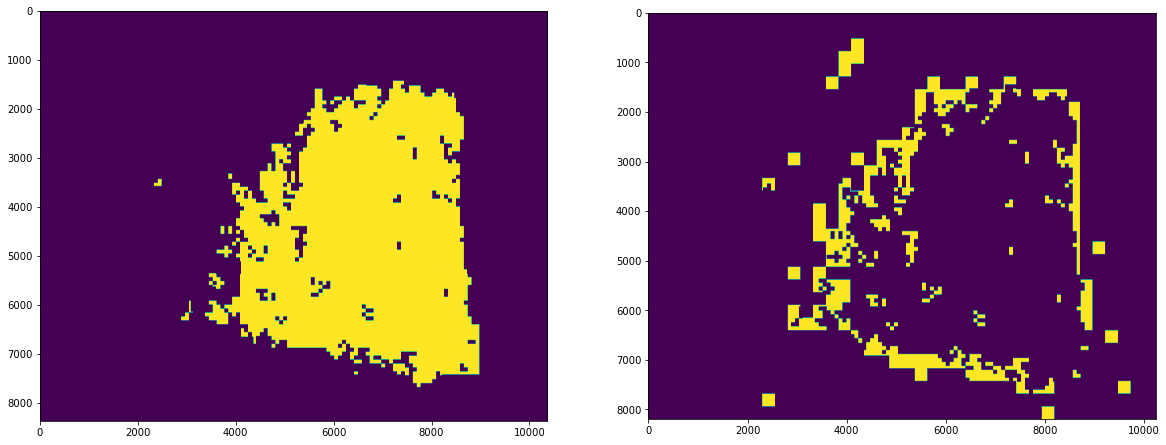

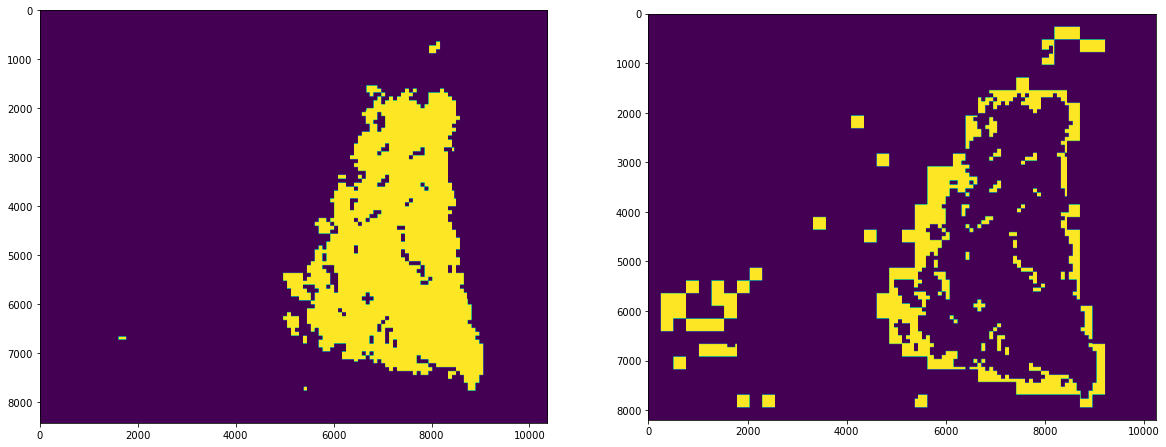

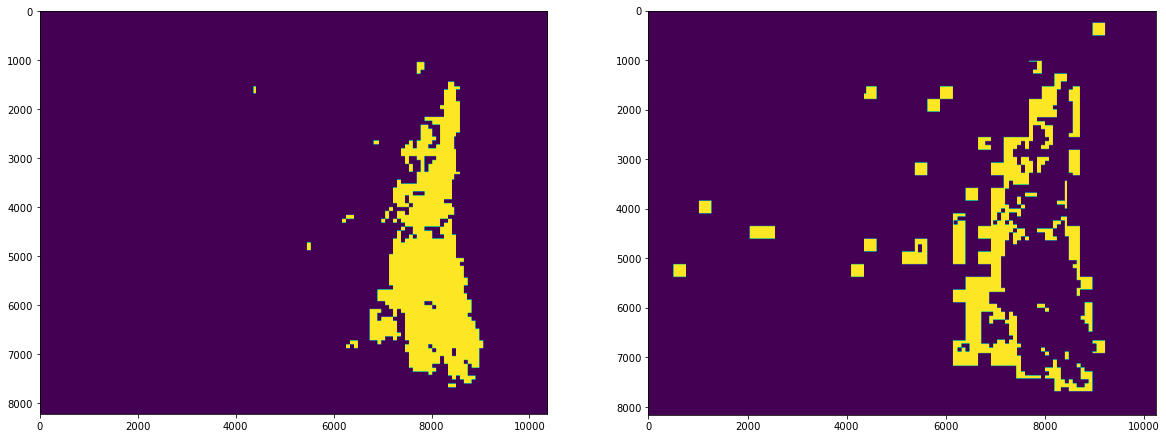

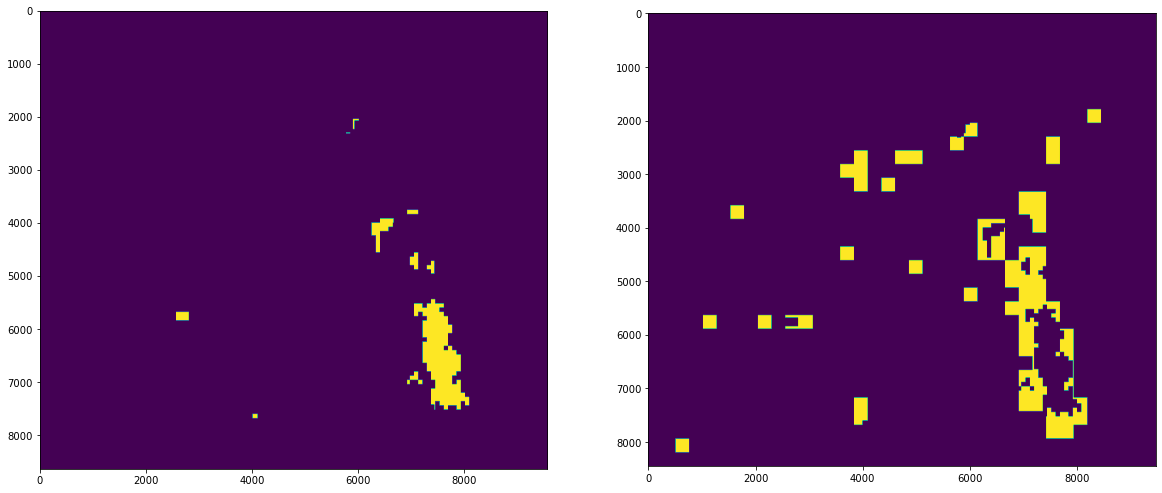

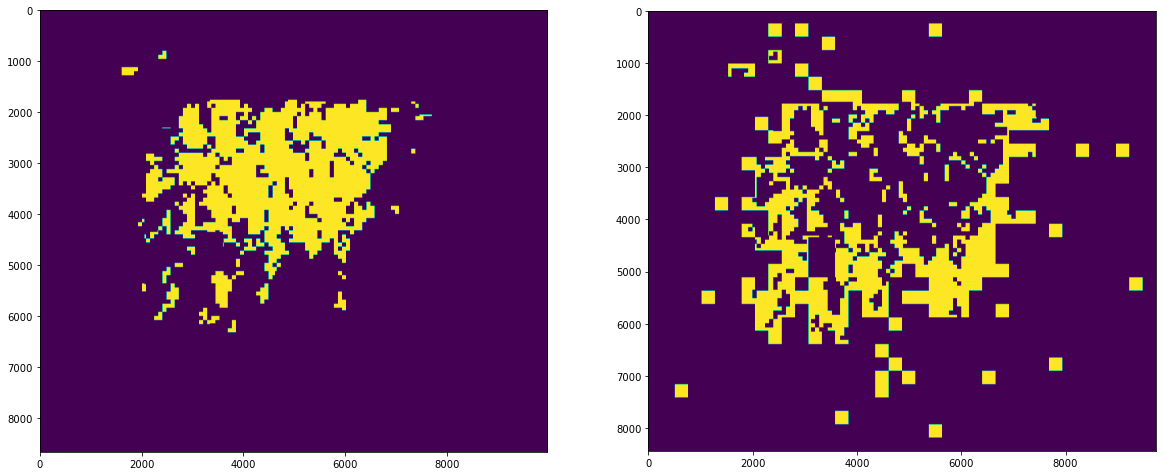

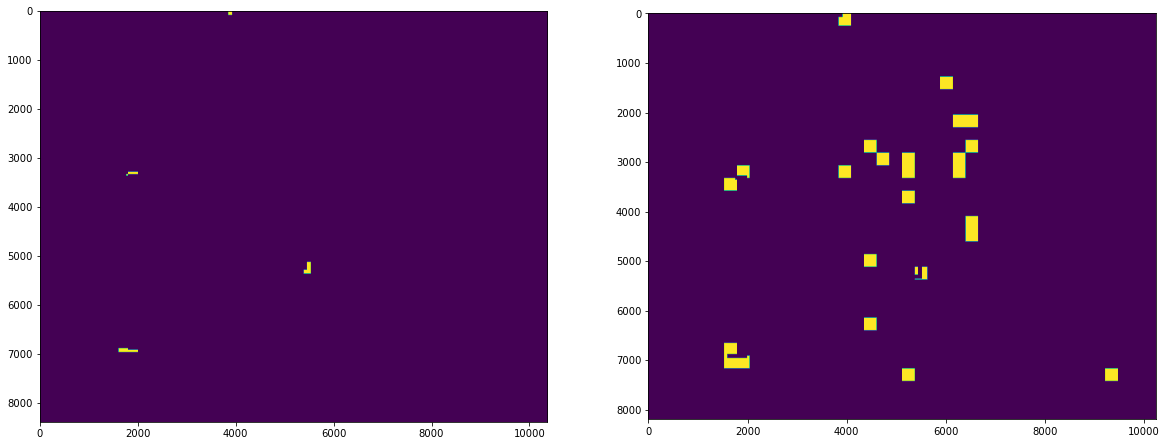

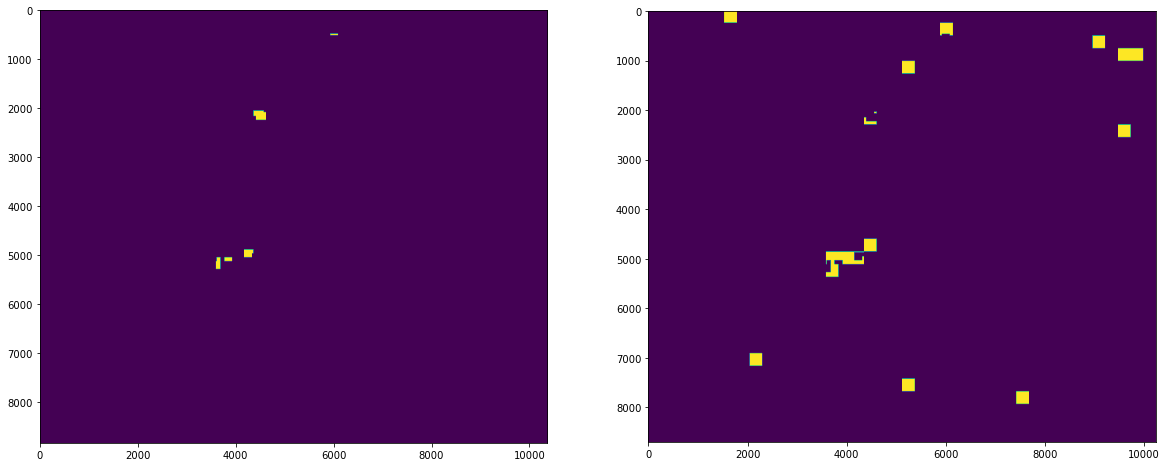

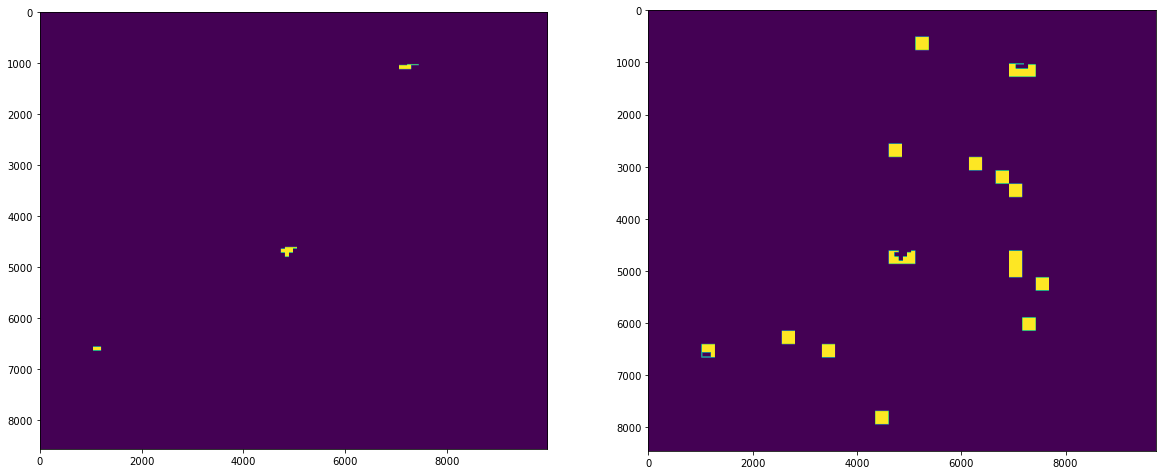

In [12]:
n_area = 0
area_part = np.zeros((2, len(filename)))
area_true = area_part.copy()

for image_path in filename[1:len(filename)]:
    # load images and masks
    path = mypath+image_path
    image = imageio.imread(path)[:,:,0:3]
    w_size = image.shape[0]
    h_size = image.shape[1]

    path = mypath+image_path
    print(image_path)

    if  w_size> h_size:
        image = np.swapaxes(image,0,1)
        tmp = w_size
        w_size = h_size
        h_size = tmp
    
    
    ############################################################################

    crop_size_big = 256
    batch_size = 50
    
    #crop image and prepare for model evaluation
    x_image = get_patches_custom(
        img_arr=image.astype(int), 
        size=crop_size_big, 
        stride=crop_size_big) 
    
    x_crops_image = torch.transpose(torch.from_numpy(x_image), 1, 3)/255
    del(x_image)

    len_dataset = x_crops_image.shape[0]
    y_crops = np.zeros((len_dataset, 1))

    testset = myDataset(data=x_crops_image.float(), targets=y_crops)
    test_loader = DataLoader(testset, batch_size = batch_size, shuffle = False)
  
    # prediction
    k=0
    total=0
    correct=0
    acc_validation=0
    predicted = np.zeros((len_dataset,1))
    labels_true = predicted.copy()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) ##########
        val, pred = torch.max(outputs.data, dim=1)
        predicted[k*batch_size:(k+1)*batch_size] = pred.unsqueeze(1)
        k=k+1

    n_w = w_size//crop_size_big
    n_h = h_size//crop_size_big

    predicted_array_big = np.reshape(predicted, (n_w, n_h))
    del(testset, test_loader)
    del(x_crops_image)

    #filtration from single fragments
    for n in range(1, n_w-1):
        for m in range(1, n_h-1):
            
            if predicted_array_big[n-1,m-1]==1 and predicted_array_big[n-1,m]==1 and predicted_array_big[n,m-1]==1 and \
            predicted_array_big[n+1,m+1]==1 and  predicted_array_big[n+1,m]==1 and  predicted_array_big[n,m+1]==1 and \
            predicted_array_big[n-1,m+1]==1 and  predicted_array_big[n+1,m-1]==1 and   predicted_array_big[n,m]!=1:

                 predicted_array_big[n,m]=1
    
    predicted_filtered_big = np.reshape(predicted_array_big, (len_dataset, 1))    

    ############################################################################

    crop_size_fine = 80
    batch_size = 2000
    
    #crop image and prepare for model evaluation
    x_image = get_patches_custom(
        img_arr=image.astype(int), 
        size=crop_size_fine, 
        stride=crop_size_fine) 
    
    x_crops_image = torch.transpose(torch.from_numpy(x_image), 1, 3)/255
    del(x_image)
    del(image)

    len_dataset = x_crops_image.shape[0]
    y_crops = np.zeros((len_dataset, 1))

    testset = myDataset(data=x_crops_image.float(), targets=y_crops)
    test_loader = DataLoader(testset, batch_size = batch_size, shuffle = False)
  
    # prediction
    k=0
    total=0
    correct=0
    acc_validation=0
    predicted2 = np.zeros((len_dataset,1))
    labels_true = predicted2.copy()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        val, pred = torch.max(outputs.data, dim=1)
        predicted2[k*batch_size:(k+1)*batch_size] = pred.unsqueeze(1)
        k=k+1

    n_w2 = w_size//crop_size_fine
    n_h2 = h_size//crop_size_fine
    
    predicted2 = 1-np.abs(predicted2-1)
    predicted_array_fine = np.reshape(predicted2, (n_w2, n_h2))
    
    #filtration from single fragments
    for n in range(1, n_w2-1):
        for m in range(1, n_h2-1):
            if predicted_array_fine[n-1,m-1]!=1 and predicted_array_fine[n-1,m]!=1 and predicted_array_fine[n,m-1]!=1 and \
            predicted_array_fine[n+1,m+1]!=1 and  predicted_array_fine[n+1,m]!=1 and  predicted_array_fine[n,m+1]!=1 and \
            predicted_array_fine[n-1,m+1]!=1 and  predicted_array_fine[n+1,m-1]!=1 and   predicted_array_fine[n,m]==1:

                 predicted_array_fine[n,m]=0 

            if predicted_array_fine[n-1,m-1]==1 and predicted_array_fine[n-1,m]==1 and predicted_array_fine[n,m-1]==1 and \
            predicted_array_fine[n+1,m+1]==1 and  predicted_array_fine[n+1,m]==1 and  predicted_array_fine[n,m+1]==1 and \
            predicted_array_fine[n-1,m+1]==1 and  predicted_array_fine[n+1,m-1]==1 and   predicted_array_fine[n,m]!=1:

                 predicted_array_fine[n,m]=1
    
    predicted_filtered_fine = np.reshape(predicted_array_fine, (len_dataset, 1))    

    del(testset, test_loader, x_crops_image)

    ############################################################################

    predicted_rescaled_big = np.kron(predicted_array_big, np.ones((crop_size_big,crop_size_big)))
    predicted_rescaled_fine = np.kron(predicted_array_fine, np.ones((crop_size_fine, crop_size_fine)))

    w_min = min( predicted_rescaled_big.shape[0],predicted_rescaled_fine.shape[0])
    h_min = min( predicted_rescaled_big.shape[1],predicted_rescaled_fine.shape[1])

    final_predicted = np.zeros((w_size, h_size))
    final_predicted[0:w_min, 0:h_min] = predicted_rescaled_big[0:w_min, 0:h_min]*predicted_rescaled_fine[0:w_min, 0:h_min]
    final_green_zone = predicted_rescaled_big[0:w_min, 0:h_min]-final_predicted[0:w_min, 0:h_min]

    area_part[0,n_area] = np.sum(np.sum(final_predicted[:,:], 0), 0)/final_predicted.shape[0]/final_predicted.shape[1]
    area_part[1,n_area] = np.sum(np.sum(final_green_zone, 0), 0)/final_green_zone.shape[0]/final_green_zone.shape[1]

    print("true area, red zone: ", str(area_true[0,n_area]), "true area, green zone: ", str(area_true[1,n_area]))   
    print("predicted area, red zone: ", str(area_part[0,n_area]), "predicted area, green zone: ", str(area_part[1,n_area]))

    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    axes = axes.flatten()
    axes[0].imshow(final_predicted)
    axes[1].imshow(final_green_zone)

    
    #path for final mask predictions
    
    imageio.imwrite(r"results_80/"+image_path[0:len(image_path)-4]+"_"+str(round(area_part[0,n_area],3))+".png", (final_predicted*255).astype('uint8'))

    del(final_predicted, final_green_zone)
    n_area = n_area+1
  
    
    

In [15]:
print(area_part.T)

[[0.37563841 0.09723395]
 [0.30050667 0.10593718]
 [0.2540127  0.07491455]
 [0.15975351 0.08703308]
 [0.07871057 0.06799326]
 [0.0160859  0.0489161 ]
 [0.11466336 0.13153845]
 [0.00077189 0.01873169]
 [0.00122037 0.01051241]
 [0.00080687 0.01271868]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
